### import necessary libraries

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

import math
import datetime
import platform

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [5]:
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [6]:
# Clear any logs from previous runs.
!rm -rf ./.logs/

In [7]:
train_data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_data = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')


## Data Overview

In [8]:
train_data.head()   # 28 * 28 = 784 pixels

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
train_data.info()   # 42,000 train data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [10]:
train_data.shape

(42000, 785)

In [11]:
test_data.info(), test_data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


(None, (28000, 784))

In [12]:
X_train = train_data.iloc[:,1:785]
y_train = train_data.iloc[:,0]

X_test = test_data.iloc[:,0:784] 

## Visualizing data with TSNE

In [13]:
X_train_tsn = X_train/255

from sklearn.manifold import TSNE
tsne_res = TSNE().fit_transform(X_train_tsn)

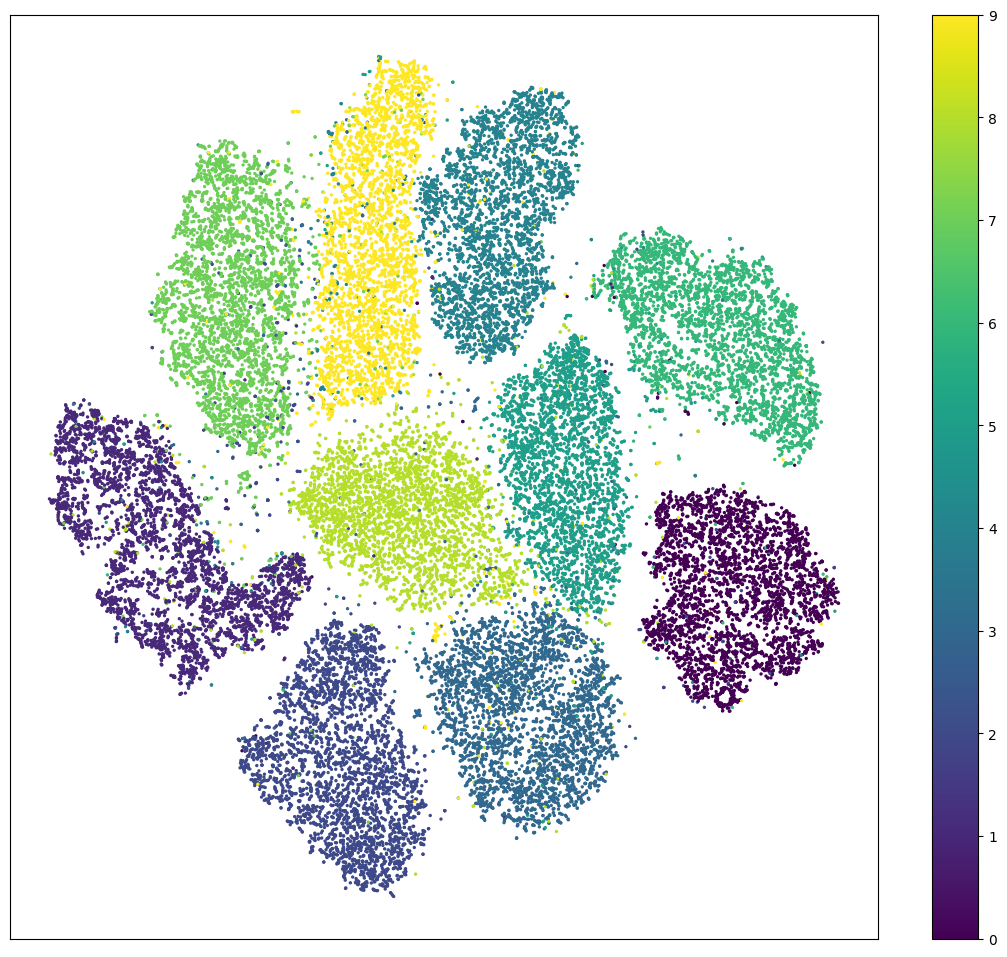

In [14]:
plt.figure(figsize=(14, 12))
plt.scatter(tsne_res[:,0], tsne_res[:,1], c=y_train, s=2)
plt.xticks([])
plt.yticks([])
plt.colorbar();

##  Splitting data into training and validation dataset

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_validation,y_train,y_validation = train_test_split(X_train,y_train,test_size=0.2,random_state=1000)

### Dimension of training and validation data

In [17]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_validation:', X_validation.shape)
print('y_validation:', y_validation.shape)

X_train: (33600, 784)
y_train: (33600,)
X_validation: (8400, 784)
y_validation: (8400,)


## Converting training, testing, and validation data into array

In [25]:
x_train_re = X_train.to_numpy().reshape(33600,28,28)
y_train_re = y_train.values
x_validation_re = X_validation.to_numpy().reshape(8400,28,28)
y_validation_re = y_validation.values
x_test_re = test_data.to_numpy().reshape(28000,28,28)

### Dimension of training, testing, and validation data after reshaping

In [27]:
print('x_train:', x_train_re.shape)
print('y_train:', y_train_re.shape)
print('x_validation:', x_validation_re.shape)
print('y_validation:', y_validation_re.shape)
print('x_test:', x_test_re.shape)

(_, IMAGE_WIDTH, IMAGE_HEIGHT) = x_train_re.shape
IMAGE_CHANNELS = 1

x_train: (33600, 28, 28)
y_train: (33600,)
x_validation: (8400, 28, 28)
y_validation: (8400,)
x_test: (28000, 28, 28)


## Explore the data

In [29]:
pd.DataFrame(x_train_re[0])  

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,113,179,254,254,76,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,253,253,253,253,135,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,253,253,253,253,66,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,250,253,253,187,5,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,39,...,222,253,253,127,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,23,175,...,253,253,186,7,0,0,0,0,0,0


### Visualise how the digits

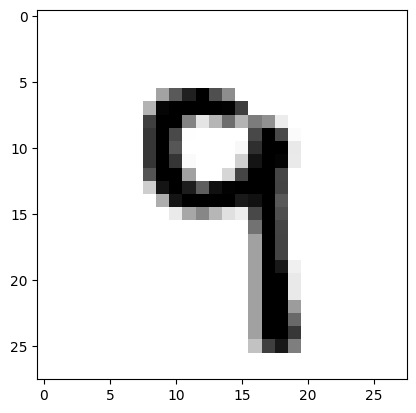

In [32]:
plt.imshow(x_train_re[6], cmap=plt.cm.binary)
plt.show()

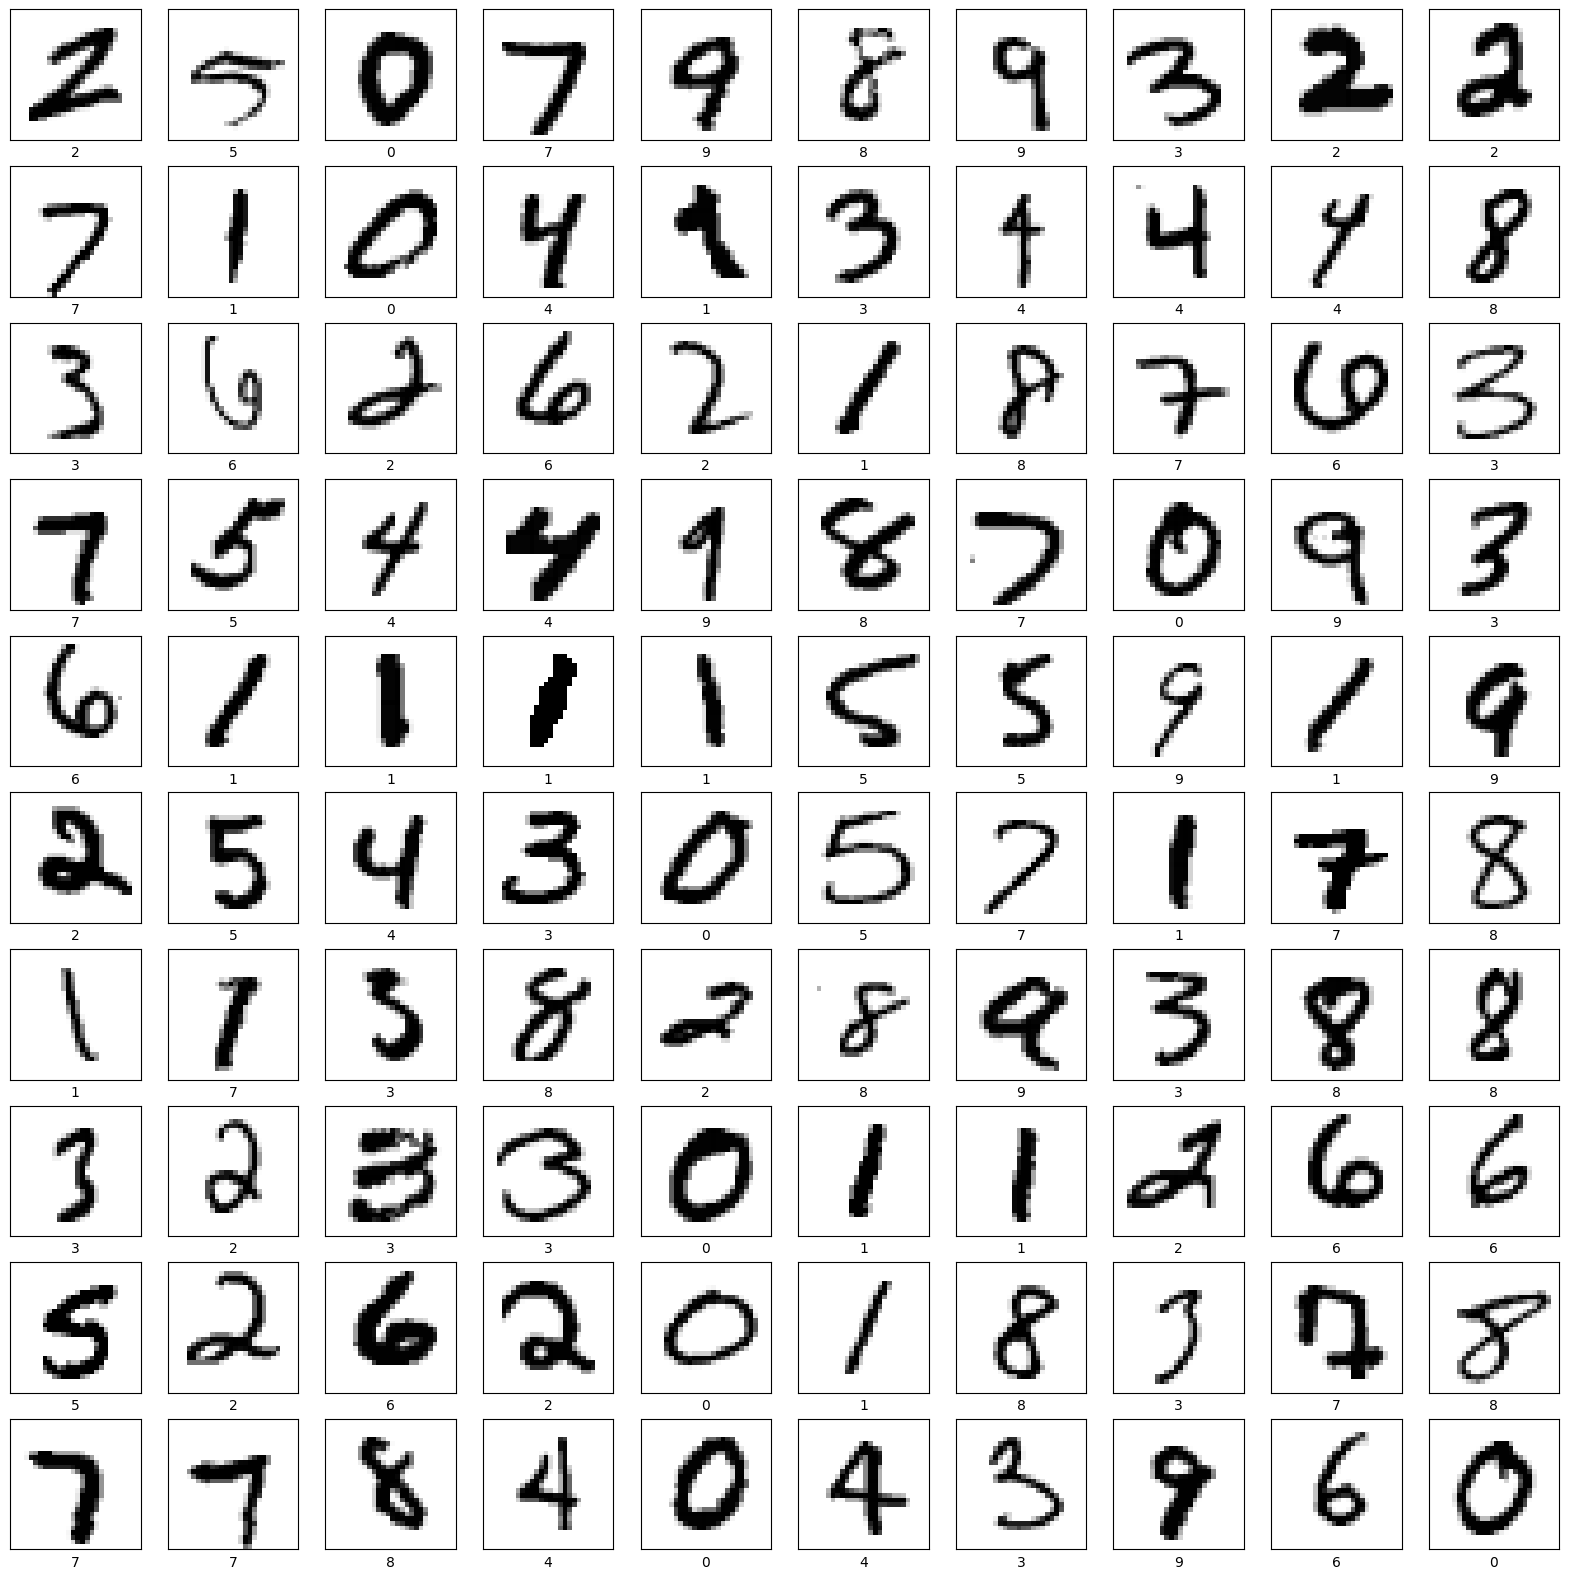

In [34]:
numbers_to_display = 100
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(20,20))
for i in range(numbers_to_display):
    plt.subplot(num_cells, num_cells, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_re[i], cmap=plt.cm.binary)
    plt.xlabel(y_train_re[i])
plt.show()

### Reshaping train, test, and validation data

In [35]:
x_train_with_chanels = x_train_re.reshape(
    x_train_re.shape[0],
    IMAGE_WIDTH,
    IMAGE_HEIGHT,
    IMAGE_CHANNELS
)

x_validation_with_chanels = x_validation_re.reshape(
    x_validation_re.shape[0],
    IMAGE_WIDTH,
    IMAGE_HEIGHT,
    IMAGE_CHANNELS
)

x_test_with_chanels = x_test_re.reshape(
    x_test_re.shape[0],
    IMAGE_WIDTH,
    IMAGE_HEIGHT,
    IMAGE_CHANNELS
)

In [36]:
print('x_train_with_chanels:', x_train_with_chanels.shape)
print('x_validation_with_chanels:', x_validation_with_chanels.shape)
print('x_test_with_chanels:', x_test_with_chanels.shape)

x_train_with_chanels: (33600, 28, 28, 1)
x_validation_with_chanels: (8400, 28, 28, 1)
x_test_with_chanels: (28000, 28, 28, 1)


## Normalize train, test, and validation data

In [38]:
x_train_normalized = x_train_with_chanels/255
x_validation_normalized = x_validation_with_chanels/255
x_test_normalized = x_test_with_chanels/255

# Build the CNN model to Classify Handwritten Digits

In [50]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Convolution2D(
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
    kernel_size=5,
    filters=8,
    strides=1,
    activation=tf.keras.activations.relu,
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

model.add(tf.keras.layers.Convolution2D(
    kernel_size=5,
    filters=16,
    strides=1,
    activation=tf.keras.activations.relu,
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

model.add(tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(
    units=128,
    activation=tf.keras.activations.relu
));

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(
    units=10,
    activation=tf.keras.activations.softmax,
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

In [51]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 8)      │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 16)       │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,610 (146.91 KB)

 Trainable params: 37,610 (146.91 KB)

 Non-trainable params: 0 (0.00 B)